In [1]:
import sys
print sys.prefix
print sys.version

/opt/mapr/EDSIADM/anaconda2/envs/pyaphp
2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


### In that notebook, we will implement the functions to normalize selected waves
The goal is to produce 4 vectors with a given dimension per selected case

## How to choose the right dimension?

In [2]:
import pyodbc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from time import gmtime, strftime
%matplotlib inline
pd.options.mode.chained_assignment = None # to avoid pandas warnings

In [3]:
# Add context and libs for Spark
import os
import sys

spark_home = os.environ.get('SPARK_HOME', "/opt/mapr/spark/spark-1.6.1")
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] ="jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']="notebook"
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

import py4j
import pyspark
import platform
import re
import shutil
from pyspark.sql import HiveContext
from pyspark.context import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql import SQLContext

In [4]:
#
# Drillbit ODBC connection
#
# conn = pyodbc.connect("DSN=MapR ODBC Driver for Drill DSN", autocommit=True)
conn = pyodbc.connect("DSN=drill_eds", autocommit=True)

In [5]:
def df_from_query(conn, query):
    """
    Query an ODBC datasource and set results in a pandas Dataframe
    
    Parameters
    ----------
    pyodbc.Connection conn : Datasource ODBC connection
    string           query : query to execute on datasource
    """
    c = conn.cursor()
    c.execute(query)
    cols = [column[0] for column in c.description]
    data = []
    for row in c.fetchall():
        data.append(tuple(row))
    df = pd.DataFrame(data, columns=cols)
    return df

In [6]:
#
# functions to use spark
#
def create_spark_contexts():
    conf = (SparkConf()
           .setMaster("local")
           .setAppName("PySparkShell")
           .set("spark.executor.memory", "8g")
           .set("spark.core.connection.ack.wait.timeout", "600")
           .set("spark.akka.frameSize", "512")
           .set("spark.cassandra.output.batch.size.bytes", "131072")
      )
    # create spark context
    if SparkContext._active_spark_context is None:
        sc = SparkContext(conf = conf)
    # create spark-on-hive context
    sql = SQLContext(sc)
    return sc, sql

In [7]:
q1 = "select * from nda_j1_deces"
df1 = df_from_query(conn, q1)
df1.head()

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT


In [8]:
q2 = "select n.id_nda, n.j1, min(s.dt_insert) as dt_min, max(s.dt_insert) as dt_max \
from nda_j1_deces n, icu_sensor_util s \
where CAST(n.id_nda as VARCHAR) = CAST(s.id_nda as VARCHAR) \
and CAST(n.j1 as VARCHAR) = CAST(s.dt_deb as VARCHAR) \
group by n.id_nda, n.j1 \
order by n.id_nda, n.j1"
df2 = df_from_query(conn, q2)
df2.head()

,id_nda,j1,dt_min,dt_max
0,2744589,2014-05-08,2014-05-08 00:40:00,2014-05-09 00:23:00
1,2744589,2014-06-24,2014-06-24 19:01:30,2014-06-25 18:46:11
2,2754266,2014-05-05,2014-05-05 16:44:01,2014-05-06 16:28:09
3,2758408,2014-05-12,2014-05-12 17:58:00,2014-05-13 17:40:11
4,2760623,2014-05-01,2014-05-01 12:49:01,2014-05-02 03:33:31


### the q2 query has been used to create a new table : nda_j1_dt_range for further usage.
creation via a CTAS Drill command

In [9]:
result = pd.merge(df1,df2, how='inner', on=['id_nda', 'j1'])
print(result.shape)
result.head()

(2701, 12)


,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00,2014-05-08 00:40:00,2014-05-09 00:23:00
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT,2014-05-05 16:44:01,2014-05-06 16:28:09
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00,2014-05-12 17:58:00,2014-05-13 17:40:11
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT,2014-05-01 12:49:01,2014-05-02 03:33:31


In [10]:
#
# Nombre de points moyen par cas
#
result['mean_nb_pts'] = result[['11_x', '12_x', '14_x', '15_x', '10102_x','10120_x']].T.mean().round()
result.head()

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00,2014-05-08 00:40:00,2014-05-09 00:23:00,68.0
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11,72.0
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT,2014-05-05 16:44:01,2014-05-06 16:28:09,83.0
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00,2014-05-12 17:58:00,2014-05-13 17:40:11,93.0
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT,2014-05-01 12:49:01,2014-05-02 03:33:31,60.0


In [11]:
#
# Médiane nombre de points par cas
#
result['median_nb_pts'] = result[['11_x', '12_x', '14_x', '15_x', '10102_x','10120_x']].T.median().round()
result.head(10)

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00,2014-05-08 00:40:00,2014-05-09 00:23:00,68.0,66.0
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11,72.0,96.0
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT,2014-05-05 16:44:01,2014-05-06 16:28:09,83.0,83.0
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00,2014-05-12 17:58:00,2014-05-13 17:40:11,93.0,93.0
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT,2014-05-01 12:49:01,2014-05-02 03:33:31,60.0,60.0
5,2764238,2014-05-06,NaN,NaN,48.0,48.0,47.0,46.0,83.036277,2015-04-20 22:10:00,2014-05-06 11:01:00,2014-05-07 10:42:21,47.0,48.0
6,2766830,2014-05-23,42.0,42.0,NaN,NaN,83.0,79.0,82.242300,NaT,2014-05-23 11:25:00,2014-05-24 10:48:10,62.0,60.0
7,2771773,2014-05-11,NaN,NaN,68.0,68.0,67.0,31.0,52.375086,NaT,2014-05-11 13:00:00,2014-05-12 12:14:00,58.0,68.0
8,2773618,2014-05-06,45.0,45.0,252.0,252.0,273.0,273.0,65.007529,2014-07-05 07:27:00,2014-05-06 10:58:41,2014-05-07 10:39:21,190.0,252.0
9,2778929,2014-07-14,67.0,67.0,NaN,NaN,93.0,95.0,86.751540,2014-10-15 13:16:00,2014-07-14 09:59:00,2014-07-15 09:22:39,80.0,80.0


In [12]:
print(result['mean_nb_pts'].mean())
print(result['median_nb_pts'].mean())
print(result['mean_nb_pts'].median())
print(result['median_nb_pts'].median())
print(result['mean_nb_pts'].min())
print(result['median_nb_pts'].min())
print(result['mean_nb_pts'].max())
print(result['median_nb_pts'].max())

73.3435764532
77.8859681599
69.0
80.0
8.0
10.0
323.0
279.0


In [13]:
result[result['mean_nb_pts'] < 10.].head()

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
954,7518340,2015-08-24,10.0,10.0,1.0,1.0,14.0,14.0,68.873374,2016-03-01 00:00:00,2015-08-24 15:59:00,2015-08-25 14:43:10,8.0,10.0
1510,8403711,2015-12-04,1.0,1.0,11.0,10.0,10.0,12.0,79.635866,NaT,2015-12-04 15:15:00,2015-12-05 14:31:00,8.0,10.0


In [14]:
#
# Wave dataframe to Series
#
def to_series(df_wave):
    df_wave.drop('id_measure_type', axis=1, inplace=True)
    df_wave.index = df_wave['dt_insert']
    df_wave.drop('dt_insert', axis=1, inplace=True)

#
# Separe all waves stored in a pandas DataFrame
#
def get_waves_from_pdf(all_waves):
    # get heart rate wave
    hr_wave = all_waves[all_waves['id_measure_type'] == 10102]
    to_series(hr_wave)
    # get respiration rate wave
    rr_wave = all_waves[all_waves['id_measure_type'] == 10120]
    to_series(rr_wave)
    # get systolic arterial blood pressure wave
    abps_wave = all_waves[(all_waves['id_measure_type'] == 11) | (all_waves['id_measure_type'] == 14)]
    # get diastolic arterial blood pressure wave
    abpd_wave = all_waves[(all_waves['id_measure_type'] == 12) | (all_waves['id_measure_type'] == 15)]
    # sort ABP
    abps_wave = abps_wave.sort_values(by='dt_insert', ascending=1)
    abpd_wave = abpd_wave.sort_values(by='dt_insert', ascending=1)
    to_series(abps_wave)
    to_series(abpd_wave)
    return hr_wave, rr_wave, abps_wave, abpd_wave

#
# Retrieve all waves points for a given case
#
def get_waves(conn, id_nda, j1):
    # retrieve all points per wave type
    s = "select id_measure_type, dt_insert, value_numeric from icu_sensor_util \
    where CAST(id_nda as VARCHAR) = '{}' and CAST(dt_deb as VARCHAR) = '{}' \
    order by id_measure_type, dt_insert".format(id_nda, j1)
    all_waves = df_from_query(conn, s)
    return get_waves_from_pdf(all_waves)

#
# plot waves
#
def plot_waves_from_lists(list_waves, list_labels):
    plt.figure(figsize=(15, 5))
    plt.plot(list_waves[0].index, hr.value_numeric, label=list_labels[0])
    plt.plot(list_waves[1].index, rr.value_numeric, label=list_labels[1])
    plt.plot(list_waves[2].index, abps.value_numeric, label=list_labels[2])
    plt.plot(list_waves[3].index, abpd.value_numeric, label=list_labels[3])
    plt.plot(list_waves[0].index, hr.value_numeric, '*', label=list_labels[0])
    plt.plot(list_waves[1].index, rr.value_numeric, '*', label=list_labels[1])
    plt.plot(list_waves[2].index, abps.value_numeric, '*', label=list_labels[2])
    plt.plot(list_waves[3].index, abpd.value_numeric, '*', label=list_labels[3])
    plt.legend()

#
# Get and plot waves example
#
def plot_waves(conn, id_nda, j1):
    hr, rr, abps, abpd = get_waves(conn, id_nda, j1)
    plt.figure(figsize=(15, 5))
    plt.plot(hr.index, hr.value_numeric, label='Heart rate')
    plt.plot(rr.index, rr.value_numeric, label='Respiration rate')
    plt.plot(abps.index, abps.value_numeric, label='Systolic ABP')
    plt.plot(abpd.index, abpd.value_numeric, label='Diastolic ABP')
    plt.plot(hr.index, hr.value_numeric, '*', label='Heart rate')
    plt.plot(rr.index, rr.value_numeric, '*', label='Respiration rate')
    plt.plot(abps.index, abps.value_numeric, '*', label='Systolic ABP')
    plt.plot(abpd.index, abpd.value_numeric, '*', label='Diastolic ABP')
    plt.legend()

#
# Add ranges to a time serie
#
def add_ranges(serie, dt_min, dt_max):
    stop_serie = pd.Series(index=[dt_max])
    start_serie = pd.Series(index=[dt_min])
    serie = pd.concat([start_serie, serie,stop_serie])
    serie.drop(0, axis=1, inplace=True)
    return serie

#
# Resample and interpolate a serie
#
def resample_and_interpolate(serie, delay, nb_pts):
    serie = serie.resample(str(int(delay))+'T').mean()
    if len(serie) < nb_pts:
        while len(serie) < nb_pts:
            dt_max = serie.index[len(serie)-1]
            dt_max = dt_max + timedelta(seconds=1)
            serie = pd.concat([serie, pd.Series(index=[dt_max])])
            serie.drop(0, axis=1, inplace=True)
    elif len(serie) > nb_pts:
        while len(serie) > nb_pts:
            serie = serie.drop([serie.index[len(serie)-1]])
    serie = serie.interpolate(method='time', limit=30)
    serie = serie.ffill()
    serie = serie.bfill()
    return serie

#
# resample / interpolate waves function
#
def normalize_waves(conn, id_nda, j1, nb_pts):
    """
    """
    hr, rr, abps, abpd = get_waves(conn, id_nda, j1)
    # Retrieve dates range for given case
    s = "select * from nda_j1_dt_range where CAST(id_nda as VARCHAR) = '{}' \
    and CAST(j1 as VARCHAR) = '{}'".format(id_nda, j1)
    df_dt_range = df_from_query(conn, s)
    # Estimate the interval in minutes to resample
    mn_interval = np.round(((df_dt_range['dt_max'] - df_dt_range['dt_min']).astype(int)/1e+09/nb_pts/60)[0])
    series = []
    for serie in [hr, rr, abps, abpd]:
        # add dt_min and dt_max to each time serie
        serie = add_ranges(serie, df_dt_range['dt_min'][0], df_dt_range['dt_max'][0])
        # resample and interpolate
        serie = resample_and_interpolate(serie, mn_interval, nb_pts)
        series.append(serie)
    return series[0], series[1], series[2], series[3]

#
# resample / interpolate waves function
#
def norm_waves(df_ranges, df_sensor_case, nb_pts):
    """
    """
    resultT = np.zeros((4, nb_pts), dtype=np.float)
    # separate waves
    hr, rr, abps, abpd = get_waves_from_pdf(df_sensor_case)
    df_dt_range = df_ranges[(df_ranges['id_nda']==str(df_sensor_case['id_nda'].unique()[0])) & \
                           (df_ranges['j1']==str(df_sensor_case['j1'].unique()[0]))]
    # Estimate the interval in minutes to resample
    mn_interval = np.round(((df_dt_range['dt_max'] - df_dt_range['dt_min']).astype(int) \
                            /1e+09/nb_pts/60).unique()[0])
    for i, serie in enumerate([hr, rr, abps, abpd]):
        # add dt_min and dt_max to each time serie
        serie = add_ranges(serie, df_dt_range['dt_min'], df_dt_range['dt_max'])
        # resample and interpolate
        serie = resample_and_interpolate(serie, mn_interval, nb_pts)
        resultT[i] = serie['value_numeric']
    return resultT, df_dt_range['dt_deces'].unique()[0]!="NaT"  # False when survivor / True when dead

In [15]:
# norm_waves(df_ranges, dfp_key, 96)[1]

# First case : number of points is about 96

In [16]:
result[(result['id_nda']=='2744589') & (result['j1']=='2014-06-24')]

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11,72.0,96.0


### Original waves

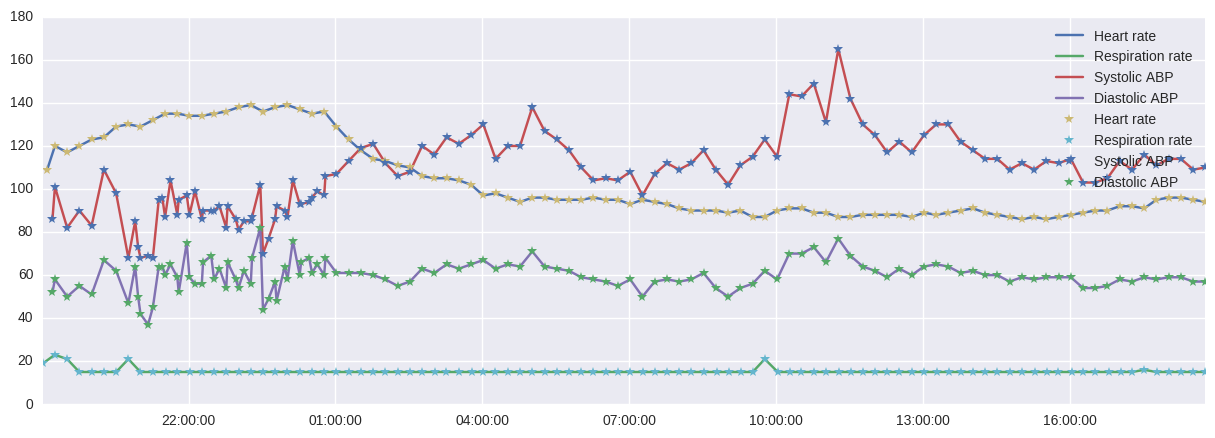

In [17]:
plot_waves(conn, 2744589, '2014-06-24')

### Resampled waves

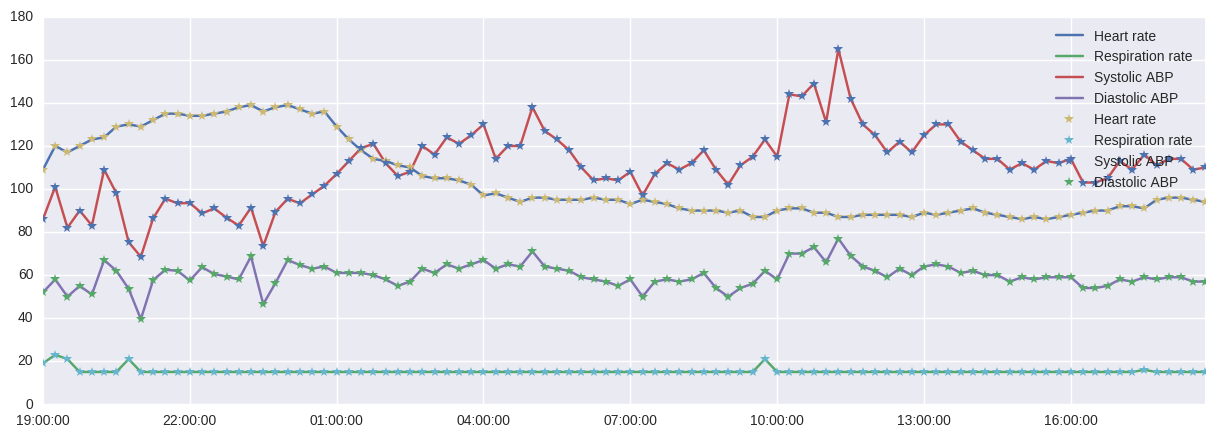

In [18]:
hr, rr, abps, abpd = normalize_waves(conn, 2744589, '2014-06-24', 96)
list_waves = [hr, rr, abps, abpd]
list_labels = ['Heart rate', 'Respiration rate', 'Systolic ABP', 'Diastolic ABP']
plot_waves_from_lists(list_waves, list_labels)

# Second case : number of points is about 60 and less

In [19]:
result[(result['id_nda']=='2818365') & (result['j1']=='2014-05-16')]

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
14,2818365,2014-05-16,29.0,29.0,NaN,NaN,57.0,57.0,59.926078,NaT,2014-05-16 01:22:20,2014-05-16 15:51:01,43.0,43.0


### Original waves

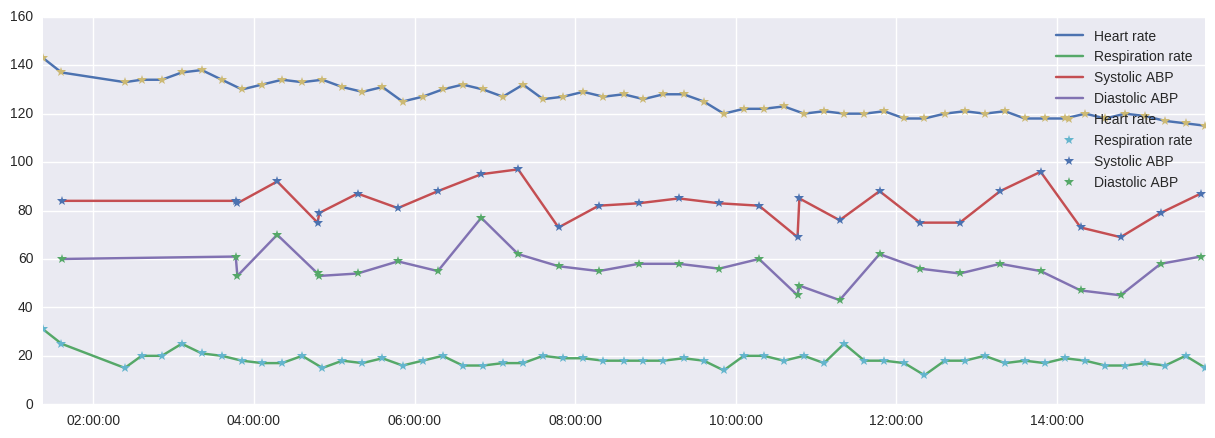

In [20]:
# Other case : 2818365 2014-05-16
plot_waves(conn, 2818365, '2014-05-16')

### Resampled waves

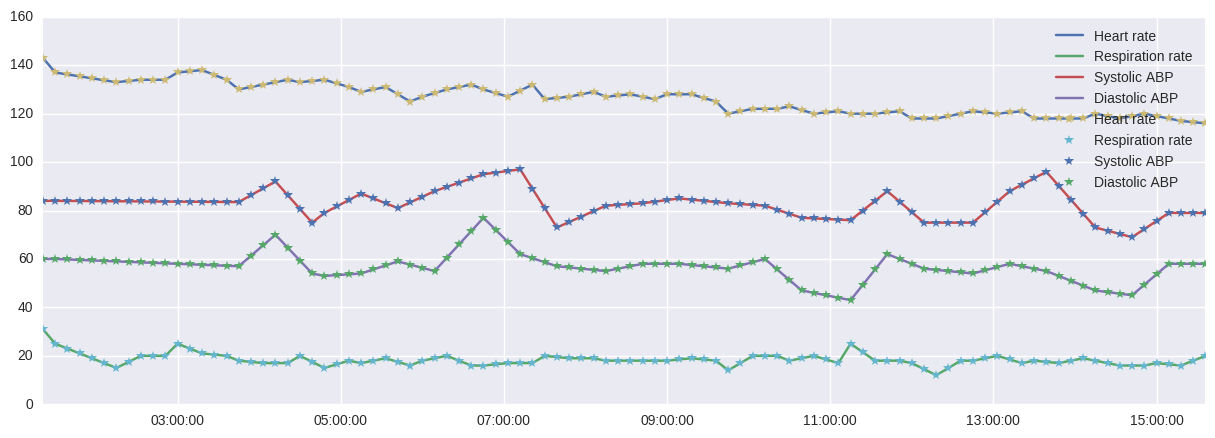

In [21]:
hr, rr, abps, abpd = normalize_waves(conn, 2818365, '2014-05-16', 96)
list_waves = [hr, rr, abps, abpd]
list_labels = ['Heart rate', 'Respiration rate', 'Systolic ABP', 'Diastolic ABP']
plot_waves_from_lists(list_waves, list_labels)

In [22]:
hr.head()

,value_numeric
2014-05-16 01:21:00,143.0
2014-05-16 01:30:00,137.0
2014-05-16 01:39:00,136.2
2014-05-16 01:48:00,135.4
2014-05-16 01:57:00,134.6


# Third case : number of points is more than 96

In [23]:
result[(result['id_nda']=='2773618') & (result['j1']=='2014-05-06')]

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
8,2773618,2014-05-06,45.0,45.0,252.0,252.0,273.0,273.0,65.007529,2014-07-05 07:27:00,2014-05-06 10:58:41,2014-05-07 10:39:21,190.0,252.0


### Original waves

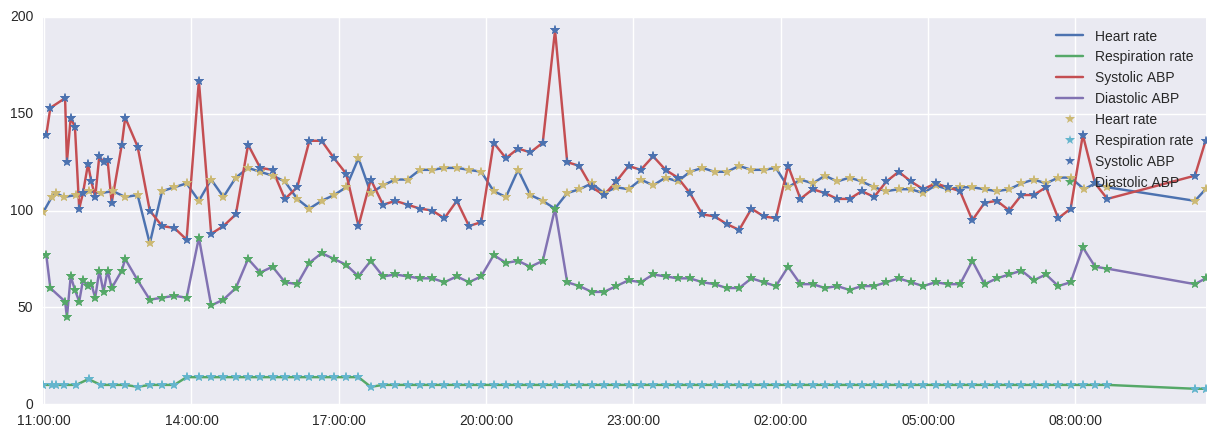

In [24]:
# 2773618 2014-05-06
plot_waves(conn, 2773618, '2014-05-06')

### Resampled waves

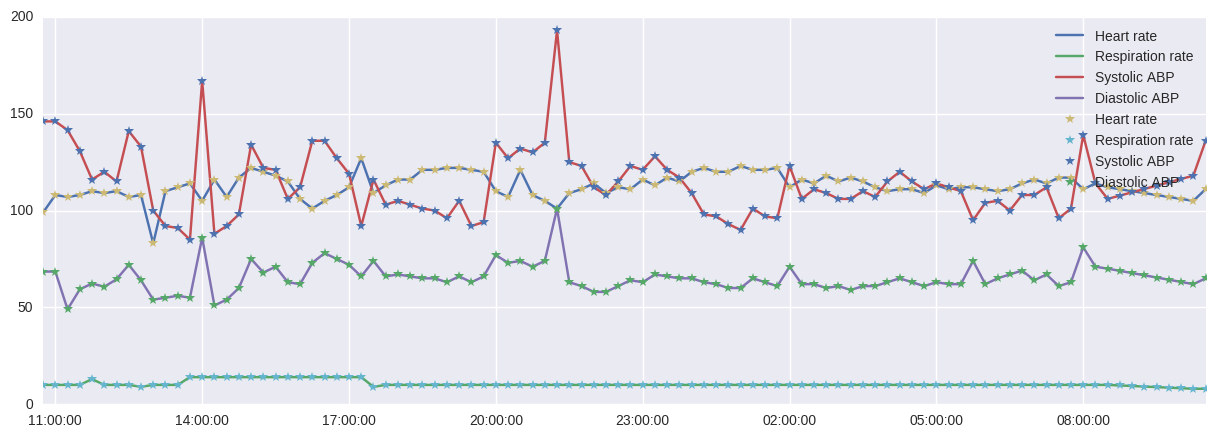

In [25]:
hr, rr, abps, abpd = normalize_waves(conn, 2773618, '2014-05-06', 96)
list_waves = [hr, rr, abps, abpd]
list_labels = ['Heart rate', 'Respiration rate', 'Systolic ABP', 'Diastolic ABP']
plot_waves_from_lists(list_waves, list_labels)

# Process the 2701 rows with a mini-batch processing
Parameters:<br>
<ul>
<li>nb_splits : number of blocks to create (mini-batch will be operated by block)</li>
<li>nb_pts : number of points generated by the resampling task</li>
</ul>

In [26]:
#
# Store duration intervals and death date in a pandas DataFrame
#
s = "select t1.id_nda, t1.j1, t1.dt_min, t1.dt_max, t2.dt_deces \
from nda_j1_dt_range t1, nda_j1_deces t2 \
where t1.id_nda = t2.id_nda and t1.j1 = t2.j1"
df_ranges = df_from_query(conn, s)
df_ranges['id_nda'] = df_ranges['id_nda'].astype(str)
df_ranges['j1'] = df_ranges['j1'].astype(str)
df_ranges['dt_min'] = pd.to_datetime(df_ranges['dt_min'])
df_ranges['dt_max'] = pd.to_datetime(df_ranges['dt_max'])

In [27]:
sc, sql = create_spark_contexts()

In [28]:
from pyspark.sql.functions import concat, col, lit

dfs_ids = sql.read.parquet("/user/mapr/eds/nda_j1_deces") \
            .select(concat('id_nda', 'j1').alias('id_case')).distinct()
dfs_ids.limit(10).show()
nb_rows = dfs_ids.count()

+-----------------+
|          id_case|
+-----------------+
|30746402014-06-27|
|31656752014-07-18|
|69605712015-07-03|
|74590332015-08-10|
|78500302015-10-15|
|78763462015-10-11|
|83639802015-11-30|
|87767962016-01-19|
|94394742016-03-19|
|96685912016-04-14|
+-----------------+



In [29]:
#
# Build the 3d pyriemann input matrix by blocks with selected waves
#
def build_pyriemann_input_matrix(nb_splits, nb_pts):
    # split dfs_ids in nb_splits RDDs
    rdd_ids_blocks = dfs_ids.rdd.randomSplit([nb_splits]*nb_splits,42)
    matrix3d = []
    target_vector = []
    # Process by blocks
    for i, rdd in enumerate(rdd_ids_blocks):
        print ("block {} / {}".format(i+1, len(rdd_ids_blocks)))
        # convert to Dataframe
        df_block = rdd.toDF()
        # save as temporary parquet file
        df_block.write.parquet("/user/mapr/eds/tmp_nda_j1_ids", mode='overwrite')
        # prepare Drill query
        dq = "select id_nda, CAST(dt_deb as VARCHAR) as j1, \
        CONCAT(CAST(id_nda as VARCHAR), CAST(dt_deb as VARCHAR)) as id_case, \
        id_measure_type, dt_insert, value_numeric \
        from icu_sensor_util \
        where CONCAT(CAST(id_nda as VARCHAR), CAST(dt_deb as VARCHAR)) in \
        (select id_case from tmp_nda_j1_ids) \
        order by id_nda, CAST(dt_deb as VARCHAR), id_measure_type, dt_insert"
        dfp = df_from_query(conn, dq)
        keys = dfp['id_case'].unique()
        for key in keys:
            # restriction on id_case
            dfp_key = dfp[dfp['id_case']==key]
            # separe and normalize several waves by type
            # (Heart Rate / Respiration rate / ABP systolic / ABP diastolic)
            xy4case = norm_waves(df_ranges, dfp_key, nb_pts)
            matrix3d.append(xy4case[0])
            target_vector.append(xy4case[1])
        print("{} keys processed".format(np.size(keys)))
    return np.stack(matrix3d), target_vector

In [30]:
nb_splits = 6
nb_pts = 96

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
pr = build_pyriemann_input_matrix(nb_splits, nb_pts)
pr_3d_matrix = pr[0]
tgt_vector = pr[1]
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
print pr_3d_matrix.shape, np.size(tgt_vector)

2016-09-23 09:38:56
block 1 / 6
491 keys processed
block 2 / 6
441 keys processed
block 3 / 6
450 keys processed
block 4 / 6
431 keys processed
block 5 / 6
459 keys processed
block 6 / 6
429 keys processed
2016-09-23 09:50:02
(2701, 4, 96) 2701


In [34]:
# Save 3D matrix in file
np.save("icu_matrix1.pyriemann", pr_3d_matrix)
np.save("icu_target1.pyriemann", tgt_vector)

In [36]:
## Check mortality rate
print(len(np.nonzero(tgt_vector)[0]))
print(float(len(np.nonzero(tgt_vector)[0])) / float(len(tgt_vector))* 100.)

592
21.9178082192


In [37]:
# Close Spark context and release memory allocated for worker(s)
sc.stop()